# Introduction to Recurrent Neural Network Models

Recurrent neural networks (RNN) are a deep architecture designed to deal with sequential data. There are many types of sequential data such as audio, video, text and time series data. RNNs consume sequential data by processing each timestep one at a time. For each timestep processed, the RNN produces an output and a hidden state. The hidden state is passed into the next timestep and is involved in the computation. This implies that when processing a certain timestep in a sequence, the network is aware of the current timestep and everything that came before. Additionally, the model weights used for computing the outputs and hidden states are shared across time. Meaning that the model learns a time invariant mapping allowing it to handle an input sequence of any size. The general RNN architecture layout is shown in the diagram below. $X_i$ represents the input data, $h_i$ represents the hidden state and $y_i$ represents the output at timestep $i$.

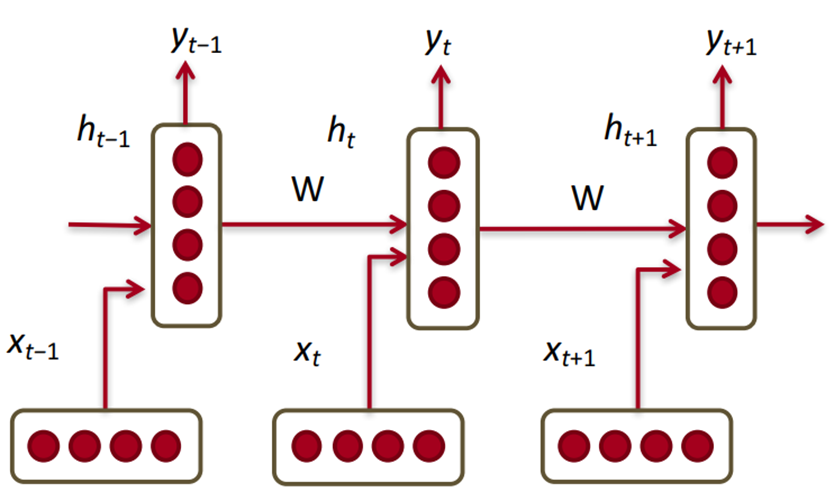


It is worth mentioning that the traditional RNN architecture suffers from vanishing and exploding gradient problems during training. Long short-term memory (LSTM) and gated recurrent units (GRU) are variants of the traditional RNN that remedy the vanishing gradient problem by modifying the cell computation and introducing new computational units called gates. These gates also improve the way information is propagated through time by learning which information to retain and which to forget. In most cases, either an LSTM or GRU are used instead of the traditional RNN.

There are several RNN configurations that change the format of the input and output:
- **One-to-one**: this reduces to a simple neural network and is rarely used.
- **One-to-many**: the input has only one timestep while the output has many. An example use case is language generation.
- **Many-to-one**: the input has many timesteps while the output has only one. An example use case is sentiment analysis.
- **Many-to-many**: both the input and output have many timesteps which may or may not be equal in size. An example use case is machine translation.

In this notebook, we will demonstrate two common applications of RNN: emotion classification which is a case of many-to-one and machine translation which is many-to-many.

## Emotion Classification

The first task is a simple emotion classification problem. Given a text sentence, our goal is to predict the kind of emotion expressed in this sentence.

We will be using the [Contextualized Affect Representations for Emotion Recognition](https://www.kaggle.com/datasets/parulpandey/emotion-dataset) dataset which contains sentences labeled a expressing one of six emotions.

We begin by downloading the dataset and loading it into a Pandas DataFrame and showing some examples.

In [2]:
#seed everything
from tensorflow.keras.utils import set_random_seed
set_random_seed(1)

In [3]:
import opendatasets as od
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/parulpandey/emotion-dataset")

Skipping, found downloaded files in ".\emotion-dataset" (use force=True to force download)


In [4]:
import pickle
import pandas as pd

df_train = pd.read_csv('emotion-dataset/training.csv')
df_test = pd.read_csv('emotion-dataset/test.csv')

## 1) Data Preprocessing

- For each datasets, plot the histogram of "emotions" to see the different classes and their distribution.

In [6]:
import pandas as pd         # For data manipulation
import matplotlib.pyplot as plt  # For basic plotting
import seaborn as sns       # Optional: For more styled plots


In [7]:
print(df_train.columns)
print(df_test.columns)


Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


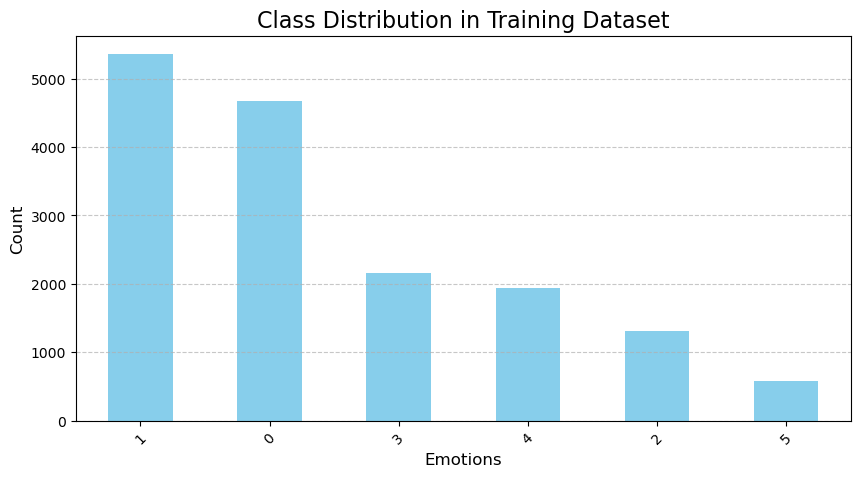

In [8]:
# Plot histogram for training dataset
plt.figure(figsize=(10, 5))
df_train['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution in Training Dataset', fontsize=16)
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

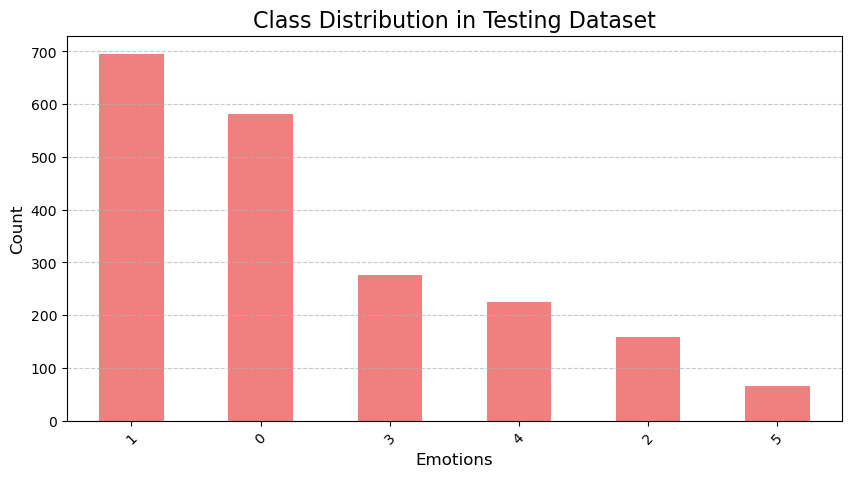

In [9]:
# Plot histogram for testing dataset
plt.figure(figsize=(10, 5))
df_test['label'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Class Distribution in Testing Dataset', fontsize=16)
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- Convert the "label" column into one-hot encoding format.
- Build a dictionary to map the one-hot encoded labels back to string form. This dictionary will be useful later when using our model to make predictions.

In [11]:
# One-hot encode the 'label' column using pd.get_dummies
df_train = pd.get_dummies(df_train, columns=['label'])
df_test = pd.get_dummies(df_test, columns=['label'])

# Display the resulting DataFrame
print(df_train.head())
print(df_test.head())


                                                text  label_0  label_1  \
0                            i didnt feel humiliated     True    False   
1  i can go from feeling so hopeless to so damned...     True    False   
2   im grabbing a minute to post i feel greedy wrong    False    False   
3  i am ever feeling nostalgic about the fireplac...    False    False   
4                               i am feeling grouchy    False    False   

   label_2  label_3  label_4  label_5  
0    False    False    False    False  
1    False    False    False    False  
2    False     True    False    False  
3     True    False    False    False  
4    False     True    False    False  
                                                text  label_0  label_1  \
0  im feeling rather rotten so im not very ambiti...     True    False   
1          im updating my blog because i feel shitty     True    False   
2  i never make her separate from me because i do...     True    False   
3  i left with my b

In [12]:
label_tostr = {
    0: 'happy',
    1: 'sad',
    2: 'angry',
    3: 'surprise',
    4: 'fear',
    5: 'neutral'
}


- Separate the data and the labels into two arrays (X and y) both for train and test datasets.

In [14]:
from sklearn.model_selection import train_test_split

# Separate input features and labels for the training dataset
X_train = df_train['text'].values  # Input text data
y_train = df_train.drop(['text'], axis=1).values  # Labels (drop the 'text' column)

# Separate input features and labels for the testing dataset
X_test = df_test['text'].values  # Input text data
y_test = df_test.drop(['text'], axis=1).values  # Labels (drop the 'text' column)

# Print the shapes to verify
print("Training Data Input Shape: ", X_train.shape)
print("Training Data Output Shape: ", y_train.shape)
print("###########################################")
print("Testing Data Input Shape: ", X_test.shape)
print("Testing Data Output Shape: ", y_test.shape)


Training Data Input Shape:  (16000,)
Training Data Output Shape:  (16000, 6)
###########################################
Testing Data Input Shape:  (2000,)
Testing Data Output Shape:  (2000, 6)


##  2) Classification Model

Until this point, each sample in our training data is a string. In order to input this data into the model, we need to split the sentences into sequences of words and have a numerical representation for each word. As a start we associate each word in the dataset's vocabulary with a unique integer number. 

Luckily, Keras provides us with the TextVectorization layer which does all of the above. Namely, this layer according to the default configuration:
- Normalizes the text (lowercase and strip punctuation).
- Tokenizes the text (split into words).
- Learns the dataset vocabulary and associates an integer with each word. A special out of vocabulary (OOV) token is reserved for unseen words.
- Replaces each word with its corresponding integer.

Additionally, this layer can be included as part of our model so we can directly input string data and it will be processed on the fly.

We can then use this data to train an Embedding layer. The Embedding layer learns a mapping from integer number to a high dimensional vector. The purpose of this layer is to learn richer and more semantically oriented vectorized representations of words as opposed to meaningless integers. The word embeddings carry more meaningful representations of words in a way that a well trained embedding layer will reflect the semantic similarity/dissimilarity of two given words in the vector space distance of their respective embeddings.

An embedding layer can be trained on language data separately and fine tuned on the application dataset. In our case, we will simply train as part of the classification model.

The outputs of the embedding layer will be input to the LSTM. Since this is a many-to-one application, we are only interested in the LSTM output at the final timestep because it encompasses the representation of all the timesteps. We connect this output to a fully connected dense layer with a Softmax activation for the classification.

- Initialize the TextVectorization layer and adapt it on the training data.

In [16]:
from tensorflow.keras.layers import TextVectorization

# Define the TextVectorization layer parameters
max_tokens = 10000  # Vocabulary size
max_len = 50        # Maximum sequence length (truncate or pad to this length)

# Instantiate the TextVectorization layer
vectorizer_layer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_len)

# Adapt the layer on training data (X_train contains 16,000 text samples)
vectorizer_layer.adapt(X_train)

# Example: Transform a sample text using the vectorizer
sample_text = "I feel amazing today!"
vectorized_sample = vectorizer_layer(sample_text)

# Output the results
print("Sample Text:", sample_text)
print("Vectorized Sample:", vectorized_sample.numpy())
print("Vocabulary Size:", len(vectorizer_layer.get_vocabulary()))


Sample Text: I feel amazing today!
Vectorized Sample: [  2   3 273 122   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Vocabulary Size: 10000


##  Build the model described above using the Sequential API.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.backend import clear_session

# Parameters
vocab_size = len(vectorizer_layer.get_vocabulary())  # Vocabulary size from the TextVectorization layer
embed_dim = 100  # Dimension for word embeddings (can be adjusted based on your choice)
hidden_dim = 64  # Number of units in the LSTM layer
num_classes = 6  # Number of output classes (since you have 6 emotions)

clear_session()

# Build the model
model = Sequential()

# Add the TextVectorization layer
model.add(vectorizer_layer)

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True))

# LSTM layer
model.add(LSTM(hidden_dim))

# Dense layer for the hidden output
model.add(Dense(64, activation='relu'))

# Dropout layer for regularization
model.add(Dropout(0.5))

# Output layer with softmax activation for classification
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 50)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 50, 100)           1000000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                        

- Train the model and plot the training and validation history. 
- Compute the model's classification metrics on the test set.

In [20]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
200/200 [==============================] - 37s 130ms/step - loss: 1.4369 - accuracy: 0.4188 - val_loss: 0.9627 - val_accuracy: 0.6538
Epoch 2/10
200/200 [==============================] - 23s 113ms/step - loss: 0.6665 - accuracy: 0.7669 - val_loss: 0.5113 - val_accuracy: 0.8294
Epoch 3/10
200/200 [==============================] - 23s 114ms/step - loss: 0.3287 - accuracy: 0.8938 - val_loss: 0.4477 - val_accuracy: 0.8703
Epoch 4/10
200/200 [==============================] - 23s 115ms/step - loss: 0.2072 - accuracy: 0.9358 - val_loss: 0.3733 - val_accuracy: 0.8834
Epoch 5/10
200/200 [==============================] - 23s 114ms/step - loss: 0.1303 - accuracy: 0.9649 - val_loss: 0.3598 - val_accuracy: 0.8938
Epoch 6/10
200/200 [==============================] - 23s 114ms/step - loss: 0.0965 - accuracy: 0.9728 - val_loss: 0.3969 - val_accuracy: 0.8900
Epoch 7/10
200/200 [==============================] - 23s 113ms/step - loss: 0.1276 - accuracy: 0.9651 - val_loss: 0.4302 - val_ac

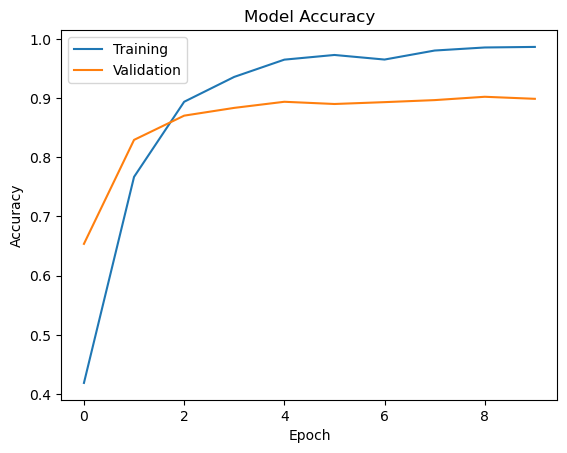

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'])  # training accuracy
plt.plot(history.history['val_accuracy'])  # validation accuracy
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show()


In [22]:
import numpy as np
from sklearn.metrics import classification_report

# Predict the class labels for the test set
y_pred = model.predict(X_test)

# Convert predictions and true labels from one-hot encoding to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes))


63/63 [==============================] - 4s 23ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       581
           1       0.93      0.93      0.93       695
           2       0.80      0.79      0.80       159
           3       0.89      0.89      0.89       275
           4       0.87      0.88      0.87       224
           5       0.67      0.64      0.65        66

    accuracy                           0.90      2000
   macro avg       0.85      0.84      0.85      2000
weighted avg       0.90      0.90      0.90      2000



**Complete the below function to use our model to infer on a given sentence and test it on a few examples.**

In [24]:
import tensorflow as tf
import numpy as np

label_tostr = {
    0: 'happy',
    1: 'sad',
    2: 'angry',
    3: 'surprise',
    4: 'fear',
    5: 'neutral'
}

def classify_sentence(input_seq, label=None):
    print('Sentence: ' + input_seq)
    
    # If a label is provided, show it as well
    if label is not None:
        print('Label: ' + label_tostr[label.argmax()])
    
    # Convert the sentence to the required format for prediction
    input_seq = tf.constant([input_seq])  # Convert sentence to tensor
    print(f"Input Sequence: {input_seq}")
    
    try:
        # Use the trained model to make a prediction
        y_pred = model.predict(input_seq)
        print(f"Prediction Output: {y_pred}")
        
        # Convert prediction to the class index
        predicted_class = np.argmax(y_pred, axis=1)[0]
        
        # Output the prediction
        print('Prediction: ' + label_tostr[predicted_class])
    except Exception as e:
        print(f"Error during prediction: {e}")
    
    print('**************************************************************')

# Example test
classify_sentence("I feel amazing today!")


Sentence: I feel amazing today!
Input Sequence: [b'I feel amazing today!']
1/1 [==============================] - 0s 54ms/step
Prediction Output: [[0.01672651 0.16742423 0.3750221  0.00390953 0.04832977 0.3885878 ]]
Prediction: neutral
**************************************************************


In [25]:
classify_sentence(X_test[0], y_test[0])
classify_sentence(X_test[1000], y_test[1000])
classify_sentence(X_test[20], y_test[20])
classify_sentence(X_test[7], y_test[7])

Sentence: im feeling rather rotten so im not very ambitious right now
Label: happy
Input Sequence: [b'im feeling rather rotten so im not very ambitious right now']
1/1 [==============================] - 0s 58ms/step
Prediction Output: [[9.9999678e-01 5.0996516e-07 6.8507436e-11 2.7474939e-06 2.7616373e-08
  8.1618184e-11]]
Prediction: happy
**************************************************************
Sentence: i grew up around this feeling living only minutes away from the gorgeous atlantic ocean in brazil so its probably no surprise i grew fond of the ocean
Label: sad
Input Sequence: [b'i grew up around this feeling living only minutes away from the gorgeous atlantic ocean in brazil so its probably no surprise i grew fond of the ocean']
1/1 [==============================] - 0s 48ms/step
Prediction Output: [[3.7013363e-06 6.8013144e-01 3.1985819e-01 1.4222323e-07 1.9140664e-06
  4.5540414e-06]]
Prediction: sad
**************************************************************
Sentence: 

## Neural Machine Translation with Seq2seq Models

Machine translation is the simple task of translating a text from one language to another. Neural machine translation is at the core of many popular translation services such as Google Translate.

One of the most common architectures for machine translation is the RNN encoder-decoder layout. In this method, an input encoder RNN consumes the input text as a sequence of tokens (represented by word embeddings). At the last time step, the hidden state of this RNN is considered to be a context vector summarizing the entire input sequence. This context vector is given to another decoder RNN as an initial hidden state. At each time step, the output of the decoder is fed through a fully connected softmax layer which predicts a token. As the decoder input, the simplest approach is to use the output from the previous timestep (starting with the start of sequence \<SOS> token). A more effective approach would be to input the ground truth translations at each timestep instead of the model's translations (which would be in many cases during training wrong). This approach is called teacher forcing and it helps the model converge faster.

This architecture is called sequence to sequence (Seq2seq) since it produces a sequence of tokens from an input sequence. It has many different applications aside from machine translation such as image captioning.

In this notebook, we will implement a basic Seq2seq model for machine translation. We will also implement Attention, which is a mechanism that addresses a key bottleneck in Seq2seq models.

To begin, let's download the data from this [collection](https://www.manythings.org/anki/) of different English translations. We will use English to French translations. In any case, it is always better to select a language that you understand so that you can assess the quality of the model's translations.

In [27]:
import requests
import zipfile
import os

# URL of the dataset
url = "http://www.manythings.org/anki/fra-eng.zip"

# Headers to mimic a real browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
}

# Step 1: Download the dataset
response = requests.get(url, headers=headers)

# Check if the response is a zip file
if response.status_code == 200 and 'zip' in response.headers.get('Content-Type', ''):
    with open("fra-eng.zip", "wb") as file:
        file.write(response.content)

    # Step 2: Unzip the dataset
    try:
        with zipfile.ZipFile("fra-eng.zip", "r") as zip_ref:
            zip_ref.extractall()  # Extract all files in the current directory
        print("Dataset downloaded and extracted successfully!")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid zip file.")
else:
    print(f"Error: Unable to download the zip file. Status code: {response.status_code}")

# Step 3: Remove the zip file
if os.path.exists("fra-eng.zip"):
    os.remove("fra-eng.zip")


Dataset downloaded and extracted successfully!


## 3) Data Loading and Preprocessing

The data is presented in a tab-separated format. The third column provides the attribution which we do not need. We can easily read this data into a Pandas DataFrame.

In order to reduce the training time we will first limit our dataset by the length of the sentences. If we look at the first few samples, we see that there are duplicate sentences for which are provided different translations. We will also discard these to further reduce the size of our dataset given that many of them simply differ in terms of punctuation and not actual translation.

We then split the data into training and testing sets.

- Load the data into a DataFrame.
- Complete the code to remove short and long sentences.
- Complete the code to drop duplicate samples.

In [29]:
import pandas as pd

# Step 1: Load the data into a DataFrame
dataset = pd.read_csv('fra.txt', sep='\t', usecols=[0, 1], names=['en', 'fr'])

# Step 2: Remove short sentences (e.g., sentences with less than 3 words)
dataset = dataset[dataset['en'].map(str.split).map(len) > 2].copy()

# Step 3: Remove long sentences (e.g., sentences with more than 15 words)
dataset = dataset[dataset['en'].map(str.split).map(len) <= 15].copy()

# Step 4: Remove duplicate sentences
dataset.drop_duplicates(subset=['en', 'fr'], inplace=True)

# Show the cleaned dataset
dataset.head()


,en,fr
481,Am I fat?,Suis-je gros ?
482,Am I fat?,Suis-je grosse ?
493,Be a man.,Sois un homme !
494,Be a man.,Soyez un homme !
508,Can I go?,Je peux y aller ?


***Complete the code to split the data.***

In [31]:
from sklearn.model_selection import train_test_split

# Prepare the input (English sentences) and output (French sentences) data
X = dataset['en'].values  # Input is the English sentences
y = dataset['fr'].values  # Output is the French sentences

# Split the data into training and testing sets
X_train_enc, X_test_enc, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing data
print("Training Data Input Shape: ", X_train_enc.shape)
print("Training Data Output Shape: ", y_train.shape)
print("Testing Data Input Shape: ", X_test_enc.shape)
print("Testing Data Output Shape: ", y_test.shape)


Training Data Input Shape:  (180321,)
Training Data Output Shape:  (180321,)
Testing Data Input Shape:  (45081,)
Testing Data Output Shape:  (45081,)


We add \<SOS> (start of sentence) and \<EOS> (end of sentence) tokens at the beginning and end of our sentences. More specifically, we add both to the encoder input data. We add only the \<SOS> token to the decoder (teacher forcing) input and only the \<EOS> token to the decoder target. This time shift between the teacher forcing input and the target is meant to desynchronize the two sequences and prevent the decoder from learning to simply copy the input to the output.

- Complete the lambda function below.

In [33]:
import numpy as np

add_eos = lambda x: x + ' <EOS>'
v_add_eos = np.vectorize(add_eos)

add_sos = lambda x: '<SOS> ' + x
v_add_sos = np.vectorize(add_sos)

X_train_enc = v_add_sos(v_add_eos(X_train_enc))  # encoder input
X_test_enc = v_add_sos(v_add_eos(X_test_enc))  # encoder input
X_train_dec = v_add_sos(y_train)  # decoder input
X_test_dec = v_add_sos(y_test)  # decoder input
y_train = v_add_eos(y_train)  # decoder ground truth
y_test = v_add_eos(y_test)  # decoder ground truth


**Define and adapt the TextVectorization layers. Define a separate layer for each of the source and target languages.**

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import numpy as np

# Define the normalize_string function
def normalize_string(input_string):
    # Convert text to lowercase
    lowercase = tf.strings.lower(input_string)
    # Remove punctuation and non-alphanumeric characters
    cleaned = tf.strings.regex_replace(lowercase, "[^a-zA-Z0-9\s]", "")
    # Trim extra spaces
    trimmed = tf.strings.strip(cleaned)
    return trimmed

# Example data (replace these with your actual data)
X_train_enc = np.array(["Hello world!", "This is a test."])
X_train_dec = np.array(["Bonjour le monde!", "Ceci est un test."])
y_train = np.array(["Salut monde", "Ceci est"])

# Adapt the TextVectorization layers with the normalize_string function
src_vectorizer = TextVectorization(standardize=normalize_string)
src_vectorizer.adapt(X_train_enc)  # Adapt to the source language (encoder input)

trg_vectorizer = TextVectorization(standardize=normalize_string)
trg_vectorizer.adapt(np.concatenate([X_train_dec, y_train]))  # Adapt to target language (decoder input + ground truth)

# Get the vocabulary sizes
src_vocab_size = len(src_vectorizer.get_vocabulary())
trg_vocab_size = len(trg_vectorizer.get_vocabulary())

print("Source Vocabulary Size:", src_vocab_size)
print("Target Vocabulary Size:", trg_vocab_size)


Source Vocabulary Size: 8
Target Vocabulary Size: 10


##  4) Seq2seq Model

Now we define the LSTM Seq2seq model described above and shown in the diagram below ([source](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)).

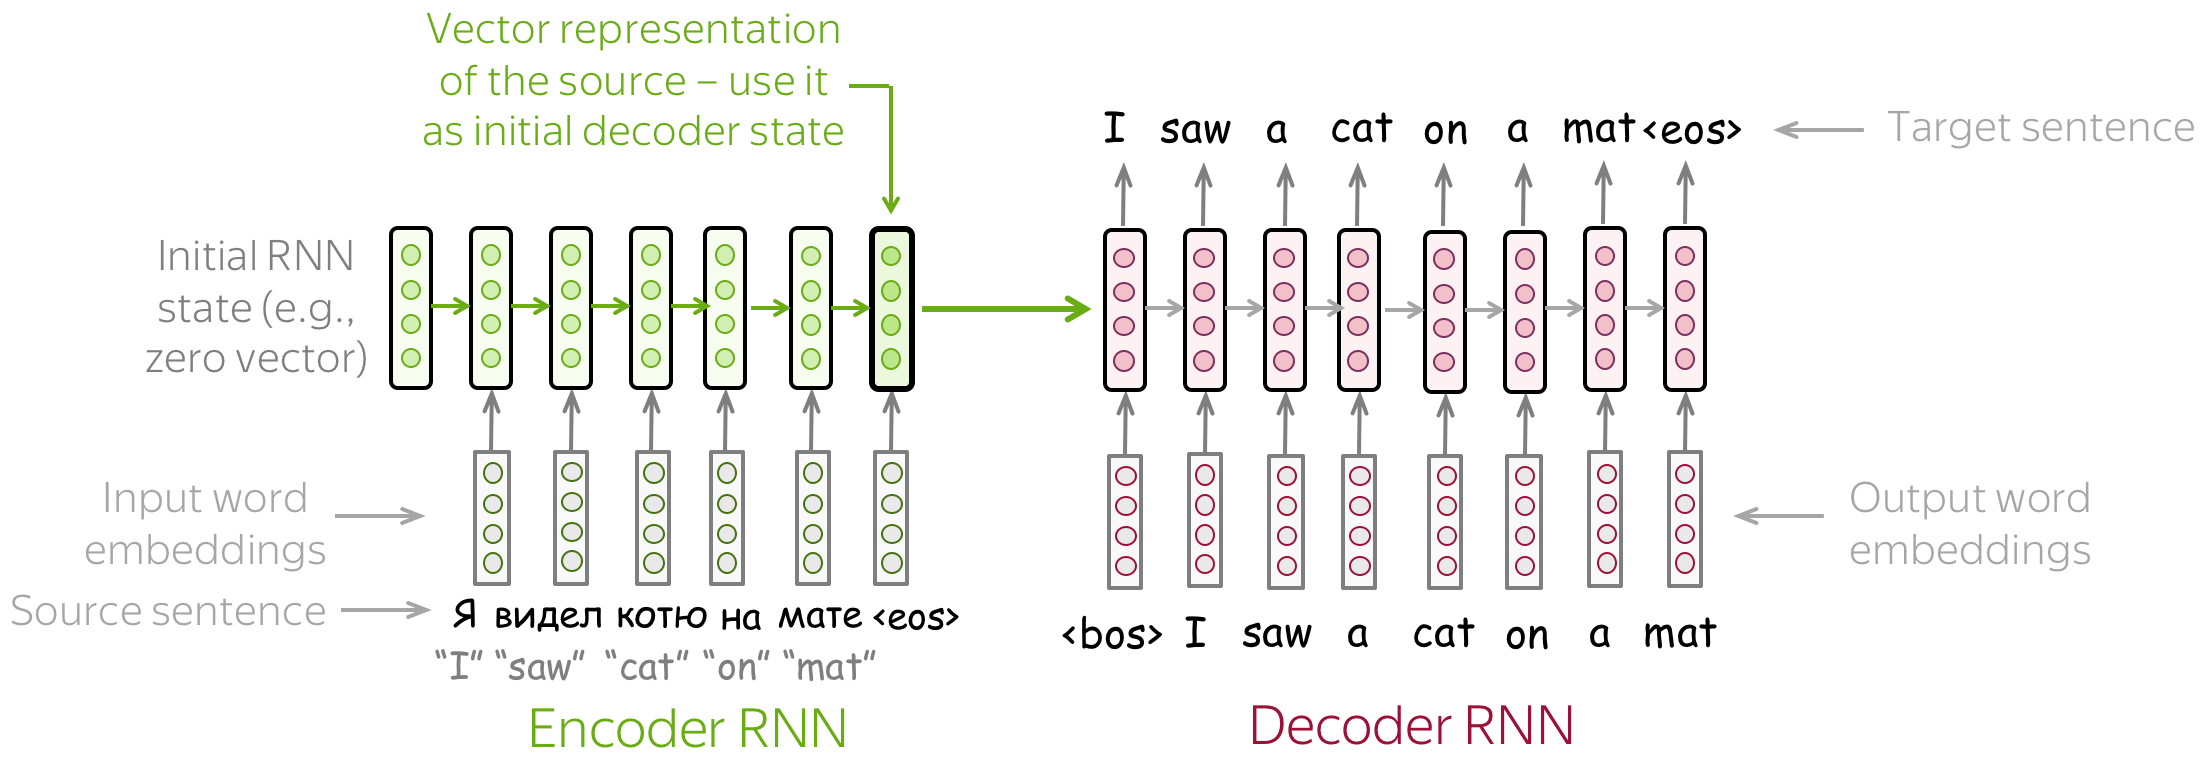

When we defined the emotion classification model earlier, we used the Keras Sequential API. The Sequential model is ideal when the desired architecture is made of linealry stacked layers where each layer's output is the input to the next layer.

However, that is not the case when it concerns our Seq2seq model. Therefore, we use the Keras Functional Model which allows the definition of more complex non-linear architectures.

- Define the model descibed above using the Functional API.

In [50]:
import tensorflow as tf
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras.layers import TextVectorization

# Define constants
src_vocab_size = 10000  # Example vocabulary size for source
tgt_vocab_size = 10000  # Example vocabulary size for target
embed_dim = 128  # Embedding dimension
latent_dim = 256  # LSTM latent dimension

# Define TextVectorization layers for source and target
src_vectorizer = TextVectorization(
    max_tokens=src_vocab_size,
    output_mode='int',
    output_sequence_length=50  # Example max sequence length for source
)
tgt_vectorizer = TextVectorization(
    max_tokens=tgt_vocab_size,
    output_mode='int',
    output_sequence_length=50  # Example max sequence length for target
)

# Define the encoder input
encoder_inputs = Input(shape=(1,), dtype='string', name="encoder_input")  # Input as (batch_size, 1)
encoder_inputs_vec = src_vectorizer(tf.squeeze(encoder_inputs, axis=-1))  # Remove the extra dimension
encoder_inputs_emb = Embedding(input_dim=src_vocab_size, output_dim=embed_dim, mask_zero=True)(encoder_inputs_vec)

# Define the encoder LSTM
encoder_lstm = LSTM(latent_dim, return_state=True, name="encoder_lstm")
_, state_h, state_c = encoder_lstm(encoder_inputs_emb)

# Store the encoder states
encoder_states = [state_h, state_c]

# Define the decoder input
decoder_inputs = Input(shape=(1,), dtype='string', name="decoder_input")  # Input as (batch_size, 1)
decoder_inputs_vec = tgt_vectorizer(tf.squeeze(decoder_inputs, axis=-1))  # Remove the extra dimension
decoder_inputs_emb = Embedding(input_dim=tgt_vocab_size, output_dim=embed_dim, mask_zero=True)(decoder_inputs_vec)

# Define the decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_emb, initial_state=encoder_states)

# Define the output layer for the decoder
decoder_dense = Dense(tgt_vocab_size, activation='softmax', name="decoder_dense")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 tf.compat.v1.squeeze (TFOpLamb  (None,)             0           ['encoder_input[0][0]']          
 da)                                                                                              
                                                                                                  
 tf.compat.v1.squeeze_1 (TFOpLa  (None,)             0           ['decoder_input[0][0]']      

**Before we proceed to train the model, we must properly represent the target data (y_train and y_test) which is still in string format.**

To avoid having to store y_train and y_test in vector format, we define a custom loss function which vectorizes its target argument using the TextVectorization layer before computing the loss. We also use the Sparse Categorical Crossentropy loss instead of the traditional Categorical Crossentropy loss since the former accepts the target in integer format as opposed to one-hot format.

- Complete the code below to define the custom loss function.

In [52]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import TextVectorization

# Simulated target vectorizer (replace with your actual TextVectorization layer)
vocab = ["hello", "world", "tensorflow", "is", "great"]
tgt_vectorizer = TextVectorization(output_sequence_length=50, vocabulary=vocab)

# Define the custom loss function
loss_fn = SparseCategoricalCrossentropy()

def custom_sparse_categorical_crossentropy(y_true, y_pred):
    # Vectorize the true labels
    y_true_vec = tgt_vectorizer(y_true)
    tf.print("Original y_true:", y_true)  # Use tf.print for the original true labels
    tf.print("Vectorized y_true:", y_true_vec)  # Use tf.print for vectorized labels
    # Compute the loss
    loss = loss_fn(y_true_vec, y_pred)
    tf.print("Computed Loss:", loss)  # Use tf.print for computed loss
    return loss

# Simulate a test case to verify the function works
# Example true labels (replace with your actual labels)
y_true = tf.constant(["hello world", "tensorflow is great"], dtype=tf.string)

# Simulated predictions (batch size = 2, sequence length = 50, vocab size = 10000)
y_pred = tf.random.uniform((2, 50, 10000), minval=0, maxval=1, dtype=tf.float32)

# Test the custom loss function
loss = custom_sparse_categorical_crossentropy(y_true, y_pred)

# Print the loss for verification
print("Loss Value:", loss.numpy())


Original y_true: ["hello world" "tensorflow is great"]
Vectorized y_true: [[2 3 0 ... 0 0 0]
 [4 5 6 ... 0 0 0]]
Computed Loss: 9.5489006
Loss Value: 9.548901


**Compile and train the model.**
**Plot the training and validation loss history.**

In [61]:
print("Shape of X_train_enc:", X_train_enc.shape)
print("Shape of X_train_dec:", X_train_dec.shape)


Shape of X_train_enc: (2,)
Shape of X_train_dec: (2,)


In [63]:
import numpy as np

# Reshape the arrays to be 2D
X_train_enc = np.array(X_train_enc).reshape(-1, 1)  # Reshape to (n_samples, n_features)
X_train_dec = np.array(X_train_dec).reshape(-1, 1)

print("New shape of X_train_enc:", X_train_enc.shape)
print("New shape of X_train_dec:", X_train_dec.shape)


New shape of X_train_enc: (2, 1)
New shape of X_train_dec: (2, 1)


In [65]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assume X_train_enc, X_train_dec, and y_train are already defined
# Convert X_train_enc and X_train_dec to numpy arrays (if not already)
X_train_enc = np.array(X_train_enc).reshape(-1, 1)  # Ensure 2D shape
X_train_dec = np.array(X_train_dec).reshape(-1, 1)

# Encode the string labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Encode training labels

# Define the model
encoder_input = tf.keras.layers.Input(shape=(X_train_enc.shape[1],))
decoder_input = tf.keras.layers.Input(shape=(X_train_dec.shape[1],))

x_enc = tf.keras.layers.Dense(64, activation='relu')(encoder_input)
x_enc = tf.keras.layers.Dropout(0.3)(x_enc)

x_dec = tf.keras.layers.Dense(64, activation='relu')(decoder_input)
x_dec = tf.keras.layers.Dropout(0.3)(x_dec)

merged = tf.keras.layers.concatenate([x_enc, x_dec])
output = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(merged)

model = tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=output)

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    [X_train_enc, X_train_dec],  # Pass both encoder and decoder inputs
    y_train,                     # Encoded labels
    epochs=10,                   # Number of epochs
    batch_size=32,               # Batch size
    validation_split=0.2         # Split 20% of data for validation
)



Epoch 1/10


UnimplementedError: Graph execution error:

Detected at node 'model_1/Cast' defined at (most recent call last):
    File "C:\Users\ADMIN\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ADMIN\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ADMIN\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\ADMIN\anaconda3\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\ADMIN\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20572\4155493321.py", line 37, in <module>
      history = model.fit(
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\functional.py", line 650, in _run_internal_graph
      y = self._conform_to_reference_input(y, ref_input=x)
    File "C:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\functional.py", line 762, in _conform_to_reference_input
      tensor = tf.cast(tensor, dtype=ref_input.dtype)
Node: 'model_1/Cast'
Cast string to float is not supported
	 [[{{node model_1/Cast}}]] [Op:__inference_train_function_51870]

In [ ]:
# Step 5: Plot training and validation loss history
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


##5) Seq2seq Inference Model

The inference model needs to be implemented separately from the training model. During inference, we cannot use teacher forcing since target data is not available during inference. The decoder input is the output of the previous time step. Therefore, we need to manually code the decoding timesteps in a loop to implement this mechanism. Also, we check at each timestep if the output is the \<EOS> sequence to terminate the sequence.

- Complete the code below to define the inference model.


In [ ]:
#define inference model
#note that this definition will use the same layer instances defined and trained earlier

#encoder same as before
encoder_model = Model(encoder_inputs, encoder_states)

#define decoder state inputs which will be intialized with the encoder states
decoder_state_input_h = Input(shape=(hidden_dim,))
decoder_state_input_c = Input(shape=(hidden_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#define decoder
#decoder states will be used as decoder state inputs while looping
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_emb, initial_state=_ _ _)
decoder_states = [state_h, state_c]

output = decoder_dense(_ _ _)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [output] + decoder_states)

- Complete the code below to define the translation routine then test it on a few samples.

In [ ]:
import tensorflow as tf

#we extract the vocabulary from the TextVectorization layer in order to inverse the mapping (from integer to string)
trg_vocab = trg_vectorizer.get_vocabulary()

def translate_sentence(input_seq, target=None):
    print('Source: ' + input_seq)
    if target is not None:
        print('Target: ' + target)
    
    #convert string to array
    input_seq = np.array(input_seq).reshape(1,1)
    #encode the input as state vectors.
    states_value = encoder_model.predict(_ _ _)

    #populate the first token of the decoder input with the start token
    dec_in = tf.reshape(tf.constant(['<SOS>']), (1,1))
    decoded_sentence = ''
    stop_condition = False

    while not stop_condition:
        #decode
        output_tokens, h, c = decoder_model.predict(_ _ _)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = trg_vocab[_ _ _]
        #store output
        decoded_sentence = decoded_sentence + ' ' + sampled_word

        #stop condition either hit max length or find stop token
        #stop token is eos and not <EOS> due to text normalization
        if (sampled_word == 'eos' or len(decoded_sentence.split()) > 30):
            stop_condition = True

        #update the next decoder input
        dec_in = tf.reshape(tf.constant([sampled_word]), (1,1))

        #update states
        states_value = [h, c]
    
    print('Translation: ' + decoded_sentence)
    print('****************************************************')

In [ ]:
translate_sentence(X_test[20], y_test[20])
translate_sentence(X_test[200], y_test[200])
translate_sentence(X_test[450], y_test[450])
translate_sentence(X_test[788], y_test[788])

##6) Attention Seq2seq Model

A major shortcoming of the traditional Seq2seq model is that the decoder has to rely on only a single vector produced by the encoder to represent the full input sequence. Attention seeks to mitigate this by informing the decoder which parts of the input sequence (encoder outputs) to "pay more attention to" at each time step. This mechanism learns to produce these attention weights according to the following process.

At each decoder time step:
- Attention score is calculated from all the encoder outputs and the current decoder output. This attention score indicates how relevant each encoder output is with respect to the current decoder output.
- A softmax operation is applied on the scores to turn the scores into a probability distribution (called attention weights).
- The attention output is a linear combination of the attention weights and the encoder outputs.
- The attention output is then combined with the decoder output to be used as input for the softmax classifier.

There are many different flavors of attention. They mainly differ in how they implement the following functions:
- How to calculate the attention score.
- How to combine the attention output with the decoder output.

In this notebook, we will implement the [Luong](https://arxiv.org/abs/1508.04025) variant which uses the following calculations:
- A bilinear function for the attention score involving a matrix of learnable weights.
- A concatenation of the attention output and decoder output through a linear layer with tanh non-linearity.

The architecture of the Luong attention is shown in the below diagram ([source](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)).

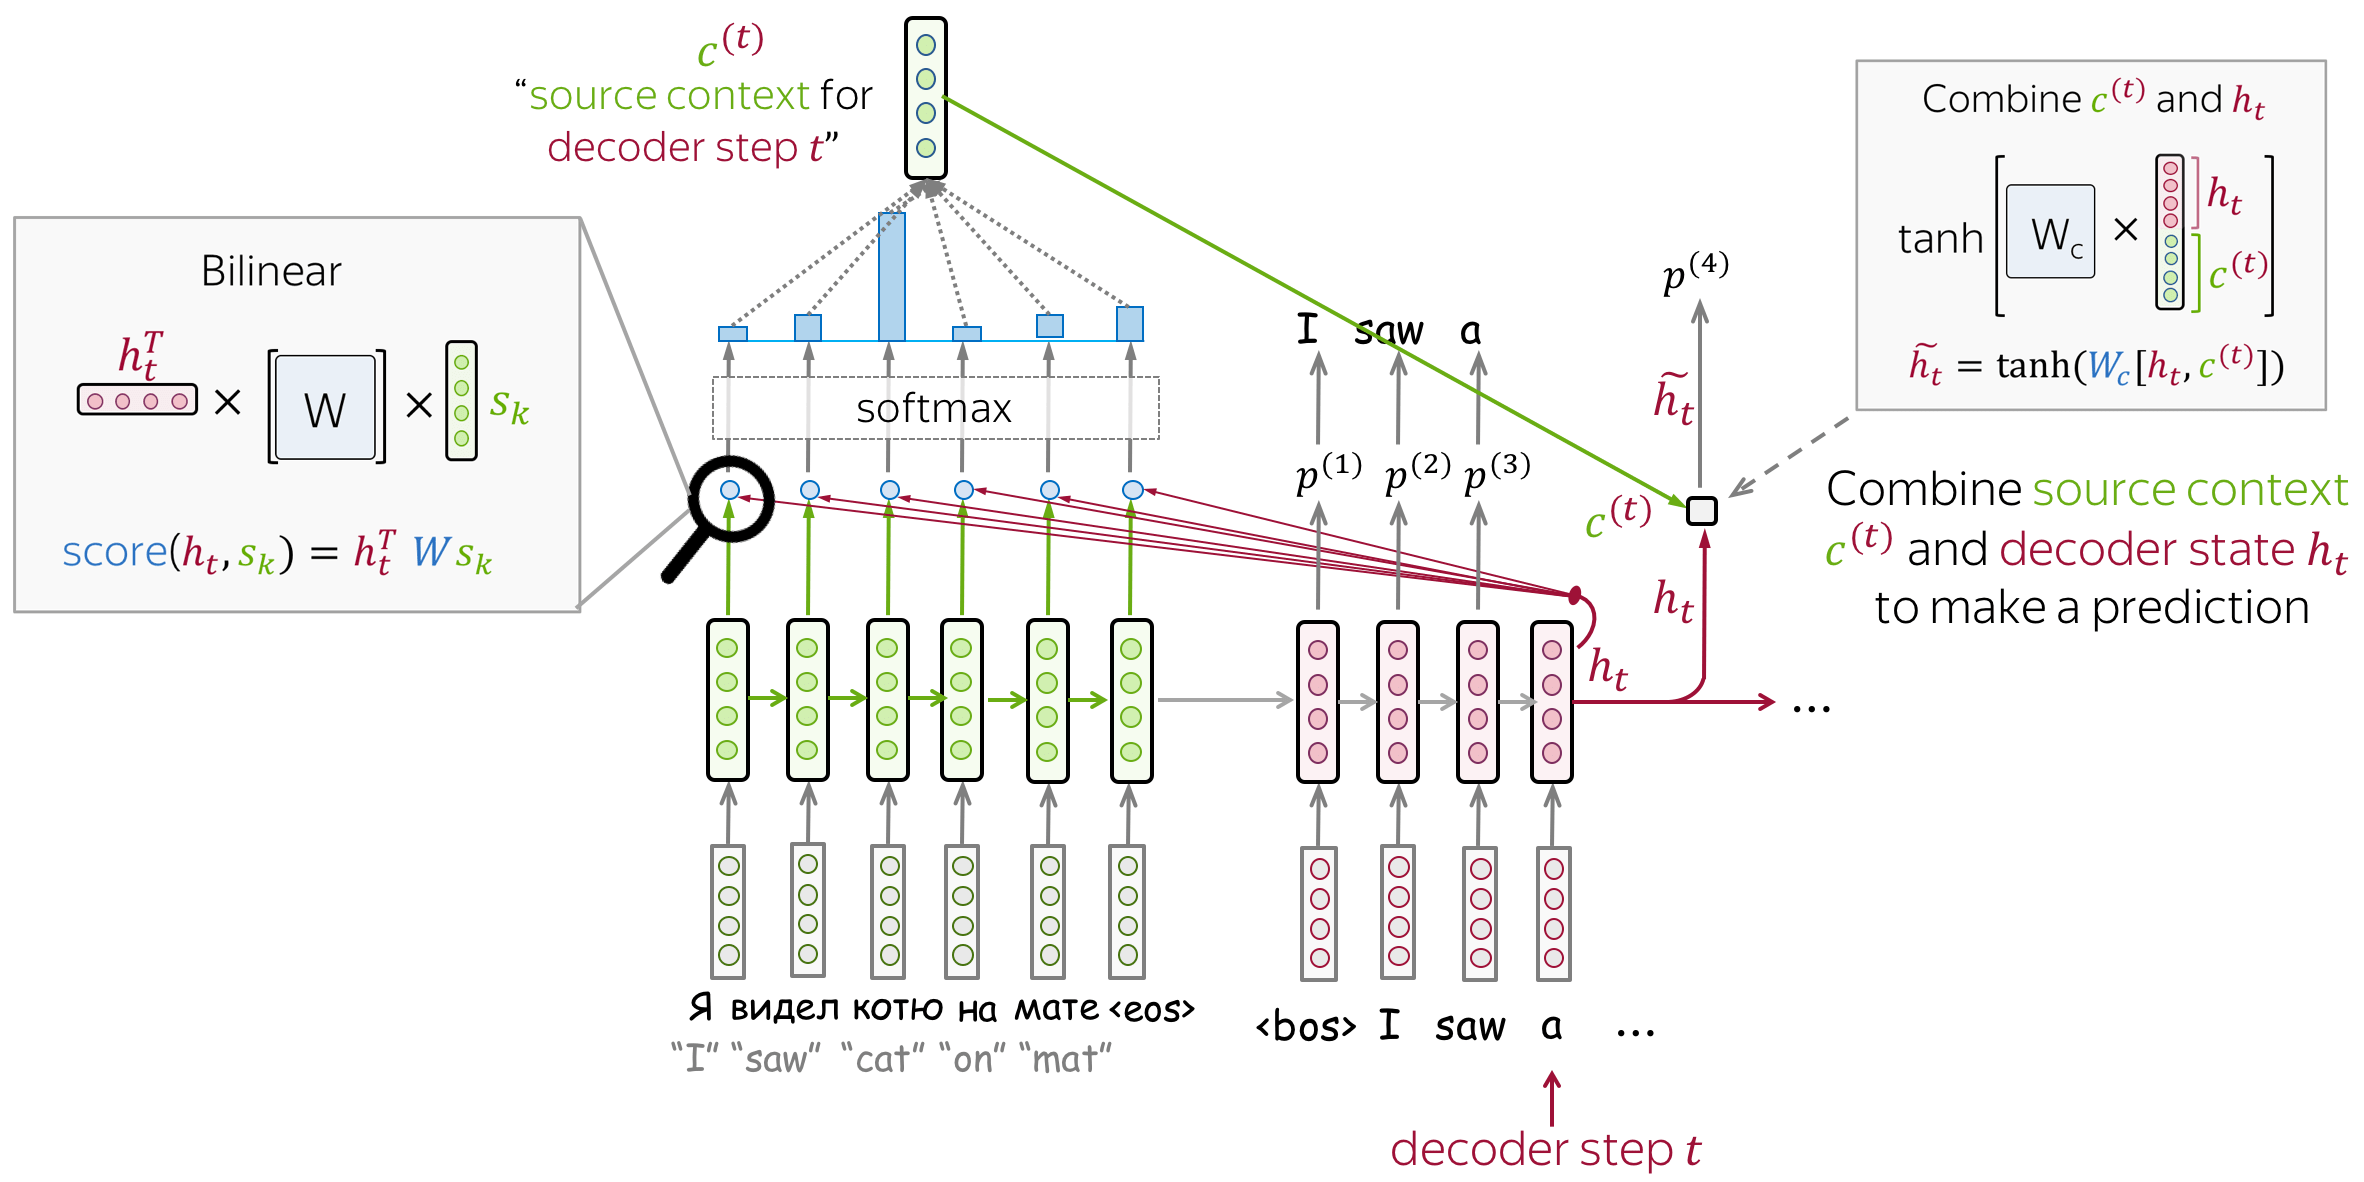

- Define the model described above using the Functional API.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session, concatenate

hidden_dim = _ _ _
embed_dim = _ _ _

clear_session()

#define an input sequence and process it
encoder_inputs = Input(shape=(1,), dtype='string')
encoder_inputs_vec = src_vectorizer(_ _ _)
encoder_inputs_emb = Embedding(input_dim=_ _ _, output_dim=embed_dim, mask_zero=True)(_ _ _)
#define the encoder lstm
#this time we need the encoder_outputs since they are involved in the attention computation
encoder_outputs, state_h, state_c = LSTM(units=hidden_dim, return_state=True, dropout=0.5)(encoder_inputs_emb)
encoder_states = [state_h, state_c]

#define the decoder, using encoder_states as initial state
decoder_inputs = Input(shape=(1,), dtype='string')
decoder_inputs_vec = _ _ _(decoder_inputs)
decoder_inputs_emb = Embedding(input_dim=_ _ _, output_dim=embed_dim, mask_zero=True)(decoder_inputs_vec)
#we set up our decoder to return full output sequences, and to return internal states as well
#we don't use the return states in the training model, but we will use them in inference
decoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_emb, initial_state=_ _ _)

#attention
#the Keras Attention layer claims to use the Luong style attention explained above
#however it uses a simple dot product to compute the attention score as opposed to Luong's bilinear function
#we will keep it that way for simplicity
attention = Attention()
#query = decoder_outputs (batch_size, 1, hidden_dim)
#value = encoder_outputs (batch_size, src_len, hidden_dim)
attention_output = attention(_ _ _)
#combine attention_output with decoder_outputs
decoder_outputs_attn = concatenate([attention_output, decoder_outputs])
attention_dense = Dense(units=hidden_dim, activation='tanh', use_bias=False)
decoder_outputs_combined = attention_dense(_ _ _)

#use a dense layer to classify each output as one of the words in the vocab
decoder_outputs_combined = Dropout(0.5)(decoder_outputs_combined)
decoder_dense = Dense(units=_ _ _, activation=_ _ _)
outputs = decoder_dense(decoder_outputs_combined)

#define and visualize the end-to-end model
model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(loss=custom_sparse_categorical_crossentropy, optimizer='adam')

plot_model(model, show_shapes=True, show_layer_names=False)

- Train the model and plot the training and validation loss history.

In [ ]:
history = model.fit([X_train_enc, X_train_dec], y_train, epochs=_ _ _, batch_size=_ _ _, validation_split=_ _ _)

_ _ _

- Similarly to the above, define the inference model and translation routine.

In [ ]:
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_dim,))
decoder_state_input_c = Input(shape=(hidden_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_emb, initial_state=_ _ _)
decoder_states = [state_h, state_c]

attention_output = attention(_ _ _)
decoder_outputs_attn = concatenate([attention_output, decoder_outputs])
decoder_outputs_combined = attention_dense(decoder_outputs_attn)
output = decoder_dense(decoder_outputs_combined)

decoder_model = Model([decoder_inputs] + decoder_states_inputs + [encoder_outputs], [output] + decoder_states)

In [ ]:
import tensorflow as tf

trg_vocab = trg_vectorizer.get_vocabulary()

def translate_sentence(input_seq, target=None):
    print('Source: ' + input_seq)
    if target is not None:
        print('Target: ' + target)
    
    #convert string to array
    input_seq = np.array(input_seq).reshape(1,1)
    #encode
    encoder_outputs, state_h, state_c  = encoder_model.predict(_ _ _)
    states_value = [state_h, state_c]

    #populate the first token of target sequence with the start token
    dec_in = tf.reshape(tf.constant(['<SOS>']), (1,1))
    decoded_sentence = ''
    stop_condition = False

    while not stop_condition:
        #here we also pass the encoder_outputs to the decoder to compute attention
        output_tokens, h, c = decoder_model.predict(_ _ _ + _ _ _ + _ _ _)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = trg_vocab[_ _ _]
        #store output
        decoded_sentence = decoded_sentence + ' ' + sampled_word

        #stop condition either hit max length or find stop token
        #stop token is eos and not <EOS> due to text normalization
        if (sampled_word == 'eos' or len(decoded_sentence.split()) > 30):
            stop_condition = True

        #update the next decoder input
        dec_in = tf.reshape(tf.constant([sampled_word]), (1,1))

        #update states
        states_value = [h, c]

    print('Translation: ' + decoded_sentence)
    print('****************************************************')

In [ ]:
translate_sentence(X_test[20], y_test[20])
translate_sentence(X_test[200], y_test[200])
translate_sentence(X_test[450], y_test[450])
translate_sentence(X_test[788], y_test[788])

References:
- Tensorflow and Keras documentation.
- [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html).
- [Sequence to Sequence (seq2seq) and Attention](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html).